In [6]:
import os
import math
import time
import numpy
import pandas
import random
import matplotlib
import numpy.random as nrand
import matplotlib.pylab as plt
from sklearn import preprocessing 

class Datum:
    def __init__(self, data,indice):
        """
        A Datum object is basically just a ND vector
        :param data: the ND vector
        """
        self.data   = data
        self.indice = indice
        self.classe  = -1

    def similarity(self, datum,vmax = 1.85 ,alpha = 1.5):
        """
        Returns the sum-squared distance between this datum and some other datum
        :param datum: the other datum
        :return: sum squared distance
        """
        diff = numpy.abs(self.data - datum.data)
        distance = math.sqrt(numpy.sum(numpy.power(diff,2)))
        v = (vmax-1) * numpy.random.random() + 1 
        return 1-(distance/(alpha*(1+(v-1)/vmax)))

    def condense(self):
        """
        A method for condensing ND into 1D for visualization ... many options exist for this
        :return: the 1D representation of the vector
        """
        return numpy.mean(self.data)

class Ant:
    def __init__(self, y, x, grid):
        """
        This initializes an ant object. This Ant class is just a dumb ant with no memory
        :param y: the y location it is initialized to
        :param x: the x location it is initialized to
        :param grid: a reference to the grid
        """
        self.loc = numpy.array([y, x])
        self.carrying = grid.get_grid()[y][x]
        self.grid = grid

    def move(self, n, c):
        """
        A recursive function for making ants move around the grid
        :param step_size: the size of each step
        """
        step_size = random.randint(1, 25)
        # Add some vector (-1,+1) * step_size to the ants location
        self.loc += nrand.randint(-1 * step_size, 1 * step_size, 2)
        # Mod the new location by the grid size to prevent overflow
        self.loc = numpy.mod(self.loc, self.grid.dim)
        # Get the object at that location on the grid
        o = self.grid.get_grid()[self.loc[0]][self.loc[1]]
        # If the cell is occupied, move again
        if o is not None:
            # If the ant is not carrying an object
            if self.carrying is None:
                # Check if the ant picks up the object
                if self.p_pick_up(n, c) >= random.random():
                    # Pick up the object and rem from grid
                    self.carrying = o
                    self.grid.get_grid()[self.loc[0]][self.loc[1]] = None
                # If not then move
                else:
                    self.move(n, c)
            # If carrying an object then just move
            else:
                self.move(n, c)
        # If on an empty cell
        else:
            if self.carrying is not None:
                # Check if the ant drops the object
                if self.p_drop(n, c) >= random.random():
                    # Drop the object at the empty location
                    self.grid.get_grid()[self.loc[0]][self.loc[1]] = self.carrying
                    self.carrying = None

    def p_pick_up(self, n, c):
        """
        Returns the probability of picking up an object
        :param n: the neighbourhood size
        :return: probability of picking up
        """
        ant = self.grid.get_grid()[self.loc[0]][self.loc[1]]
        return 1 - self.grid.get_probability(ant, self.loc[0], self.loc[1], n, c)

    def p_drop(self, n, c):
        """
        Returns the probability of dropping an object
        :return: probability of dropping
        """
        ant = self.carrying
        return self.grid.get_probability(ant, self.loc[0], self.loc[1], n, c)

class Grid:
    def __init__(self, height, width, path,vmax = 1.85 ,alpha = 1.5):
        """
        This method initializes a grid object. A grid is basically just a 2D array of Datum objects
        :param height: this is the height of the grid
        :param width: this is the width of the grid
        """
        self.path = path
        # Store the dimensions of the grid
        self.dim = numpy.array([height, width])
        # Initialize an empty numpy matrix of type Datum
        self.grid = numpy.empty((height, width), dtype=Datum)
        #speed and alpha 
        self.vmax = vmax
        self.alpha = alpha 
        # This makes the plot redraw
        plt.ion()
        plt.figure(figsize=(100, 100))
        self.max_d = 0.001
        
    def fill_grid(self,data):
        i = 0; 
        for i in range(data.shape[0]):
            ux = numpy.random.random();
            uy = numpy.random.random();
            self.grid[math.floor(uy*self.dim[0])][math.floor(ux*self.dim[1])] = Datum(data[i,:],i); 

    def matrix_grid(self):
        """
        This method condenses the grid (2D array of Datum objects) to a matrix which can be visualized
        :return: matrix of the grid
        """
        matrix = numpy.empty((self.dim[0], self.dim[1]))
        matrix.fill(0)
        for y in range(self.dim[0]):
            for x in range(self.dim[1]):
                if self.grid[y][x] is not None:
                    matrix[y][x] = self.get_grid()[y][x].classe
                else:
                    matrix[y][x] = 0 
        return matrix

    def plot_grid(self, name="first", save_figure=False):
        """
        This plots the 2D representation of the grid
        :param name: the name of the image to save
        :return:
        """
        plt.figure(figsize=(100, 100))
        plt.matshow(self.matrix_grid(), fignum=0)
        # Option to save images
        if save_figure:
            plt.savefig(self.path + name + '.png')
        # plt.draw()

    def get_grid(self):
        return self.grid

    def get_probability(self, d, y, x, n, c):
        """
        This gets the probability of drop / pickup for any given Datum, d
        :param d: the datum
        :param x: the x location of the datum / ant carrying datum
        :param y: the y location of the datum / ant carrying datum
        :param n: the size of the neighbourhood function
        :param c: constant for convergence control
        :return: the probability of
        """
        # Starting x and y locations
        y_s = y - n
        x_s = x - n
        total = 0.0
        # For each neighbour
        for i in range((n*2)+1):
            xi = (x_s + i) % self.dim[0]
            for j in range((n*2)+1):
                # If we are looking at a neighbour
                yj = (y_s + j) % self.dim[1]
                if xi != x and yj != y:
                    # Get the neighbour, o
                    o = self.grid[yj][xi]
                    # Get the similarity of o to x
                    if o is not None:
                        s = d.similarity(o,vmax= self.vmax,alpha = self.alpha)
                        total += s
        # Normalize the density by the max seen distance to date
        md = total / (math.pow(n, 2))
        density = max(md, 0)
        t = math.exp(-c * density)
        probability = (1-t)/(1+t)
        return probability

def optimize(X,height, width, ants, sims, n, c, freq=500, path="image"):
    """
    Main method for running the algorithm
    """
    # Initialize the grid
    grid = Grid(height, width,path,vmax = 1.85,alpha = 1.5)
    grid.fill_grid(data=X)
    # Create the ants
    ant_agents = []
    for i in range(ants):
        ant = Ant(random.randint(0, height - 1), random.randint(0, width - 1), grid)
        ant_agents.append(ant)
    for i in range(sims):
        for ant in ant_agents:
            ant.move(n, c)
        if i % freq == 0 :
            print(i)        
    results = labeling_objects(grid = grid, neighborhood_distance = n, minimal_neighbors = 2)
    return results
            
def labeling_objects (grid, neighborhood_distance, minimal_neighbors):
    """
    This method gives foreach object in the grid a classe according to 
    its neighbors. 
    :param grid: the grid
    :param neighborhood_distance: the maximal distance between two neighbors 
    :param minimal_neighbors: minimal number of neighbors to not be classifed as outlier (isolited)
    """
    # foreach occupied point (x,y), we search in the neighborhood ( x-n -> x+n , y-n -> y+n ) 
    # to find the right classe for our object in (x,y)
    n = neighborhood_distance; 
    c = 0  #used to create new classe 
    for y in range(grid.dim[0]):
        for x in range(grid.dim[1]):
            if grid.grid[y][x] is not None:
                #there is an object in (x,y)
                # Starting x and y locations
                y_s = y - n
                x_s = x - n
                # For each neighbour
                classes = None
                neighbors = 0
                if c > 0:
                    classes = numpy.zeros(c)
                for i in range((n*2)+1):
                    xi = (x_s + i) % grid.dim[1]
                    for j in range((n*2)+1):
                        yj = (y_s + j) % grid.dim[0]
                        # If we are looking at a neighbour
                        if xi != x and yj != y:
                            o = grid.grid[yj][xi]
                            if o is not None:
                                neighbors += 1 
                                if o.classe > 0 and classes is not None :
                                    classes[o.classe-1] +=1
                            
                if neighbors >= minimal_neighbors:
                    if classes is not None : 
                        if(numpy.amax(classes) != 0):
                            cls = numpy.where(classes == numpy.amax(classes))
                            (grid.grid[y][x]).classe = cls[0][0] + 1;
                            
                        else:
                            (grid.grid[y][x]).classe = c+1;
                            c+=1  
                            
                    else:
                        (grid.grid[y][x]).classe = c+1;
                        c +=1  
                else:
                    (grid.grid[y][x]).classe = -2;
    return {
        "number_classes": c,
        "grid": grid
    }

In [7]:
dataset1 = pandas.read_csv('iris.data', sep=",", header=None)

X_train = dataset1.iloc[:, :-1].values # Premières colonnes 
Y_train = dataset1.iloc[:,-1].values # Dernière colonne
scaler = preprocessing.StandardScaler().fit(X_train)
X_scaled = scaler.transform(X_train)


In [8]:
results = optimize(X = X_scaled,height= 100, 
                   width = 100, ants = 20, sims = 15000, n =3, c = 3, freq=100, path="image")

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500
11600
11700
11800
11900
12000
12100
12200
12300
12400
12500
12600
12700
12800
12900
13000
13100
13200
13300
13400
13500
13600
13700
13800
13900
14000
14100
14200
14300
14400
14500
14600
14700
14800
14900


<Figure size 7200x7200 with 0 Axes>

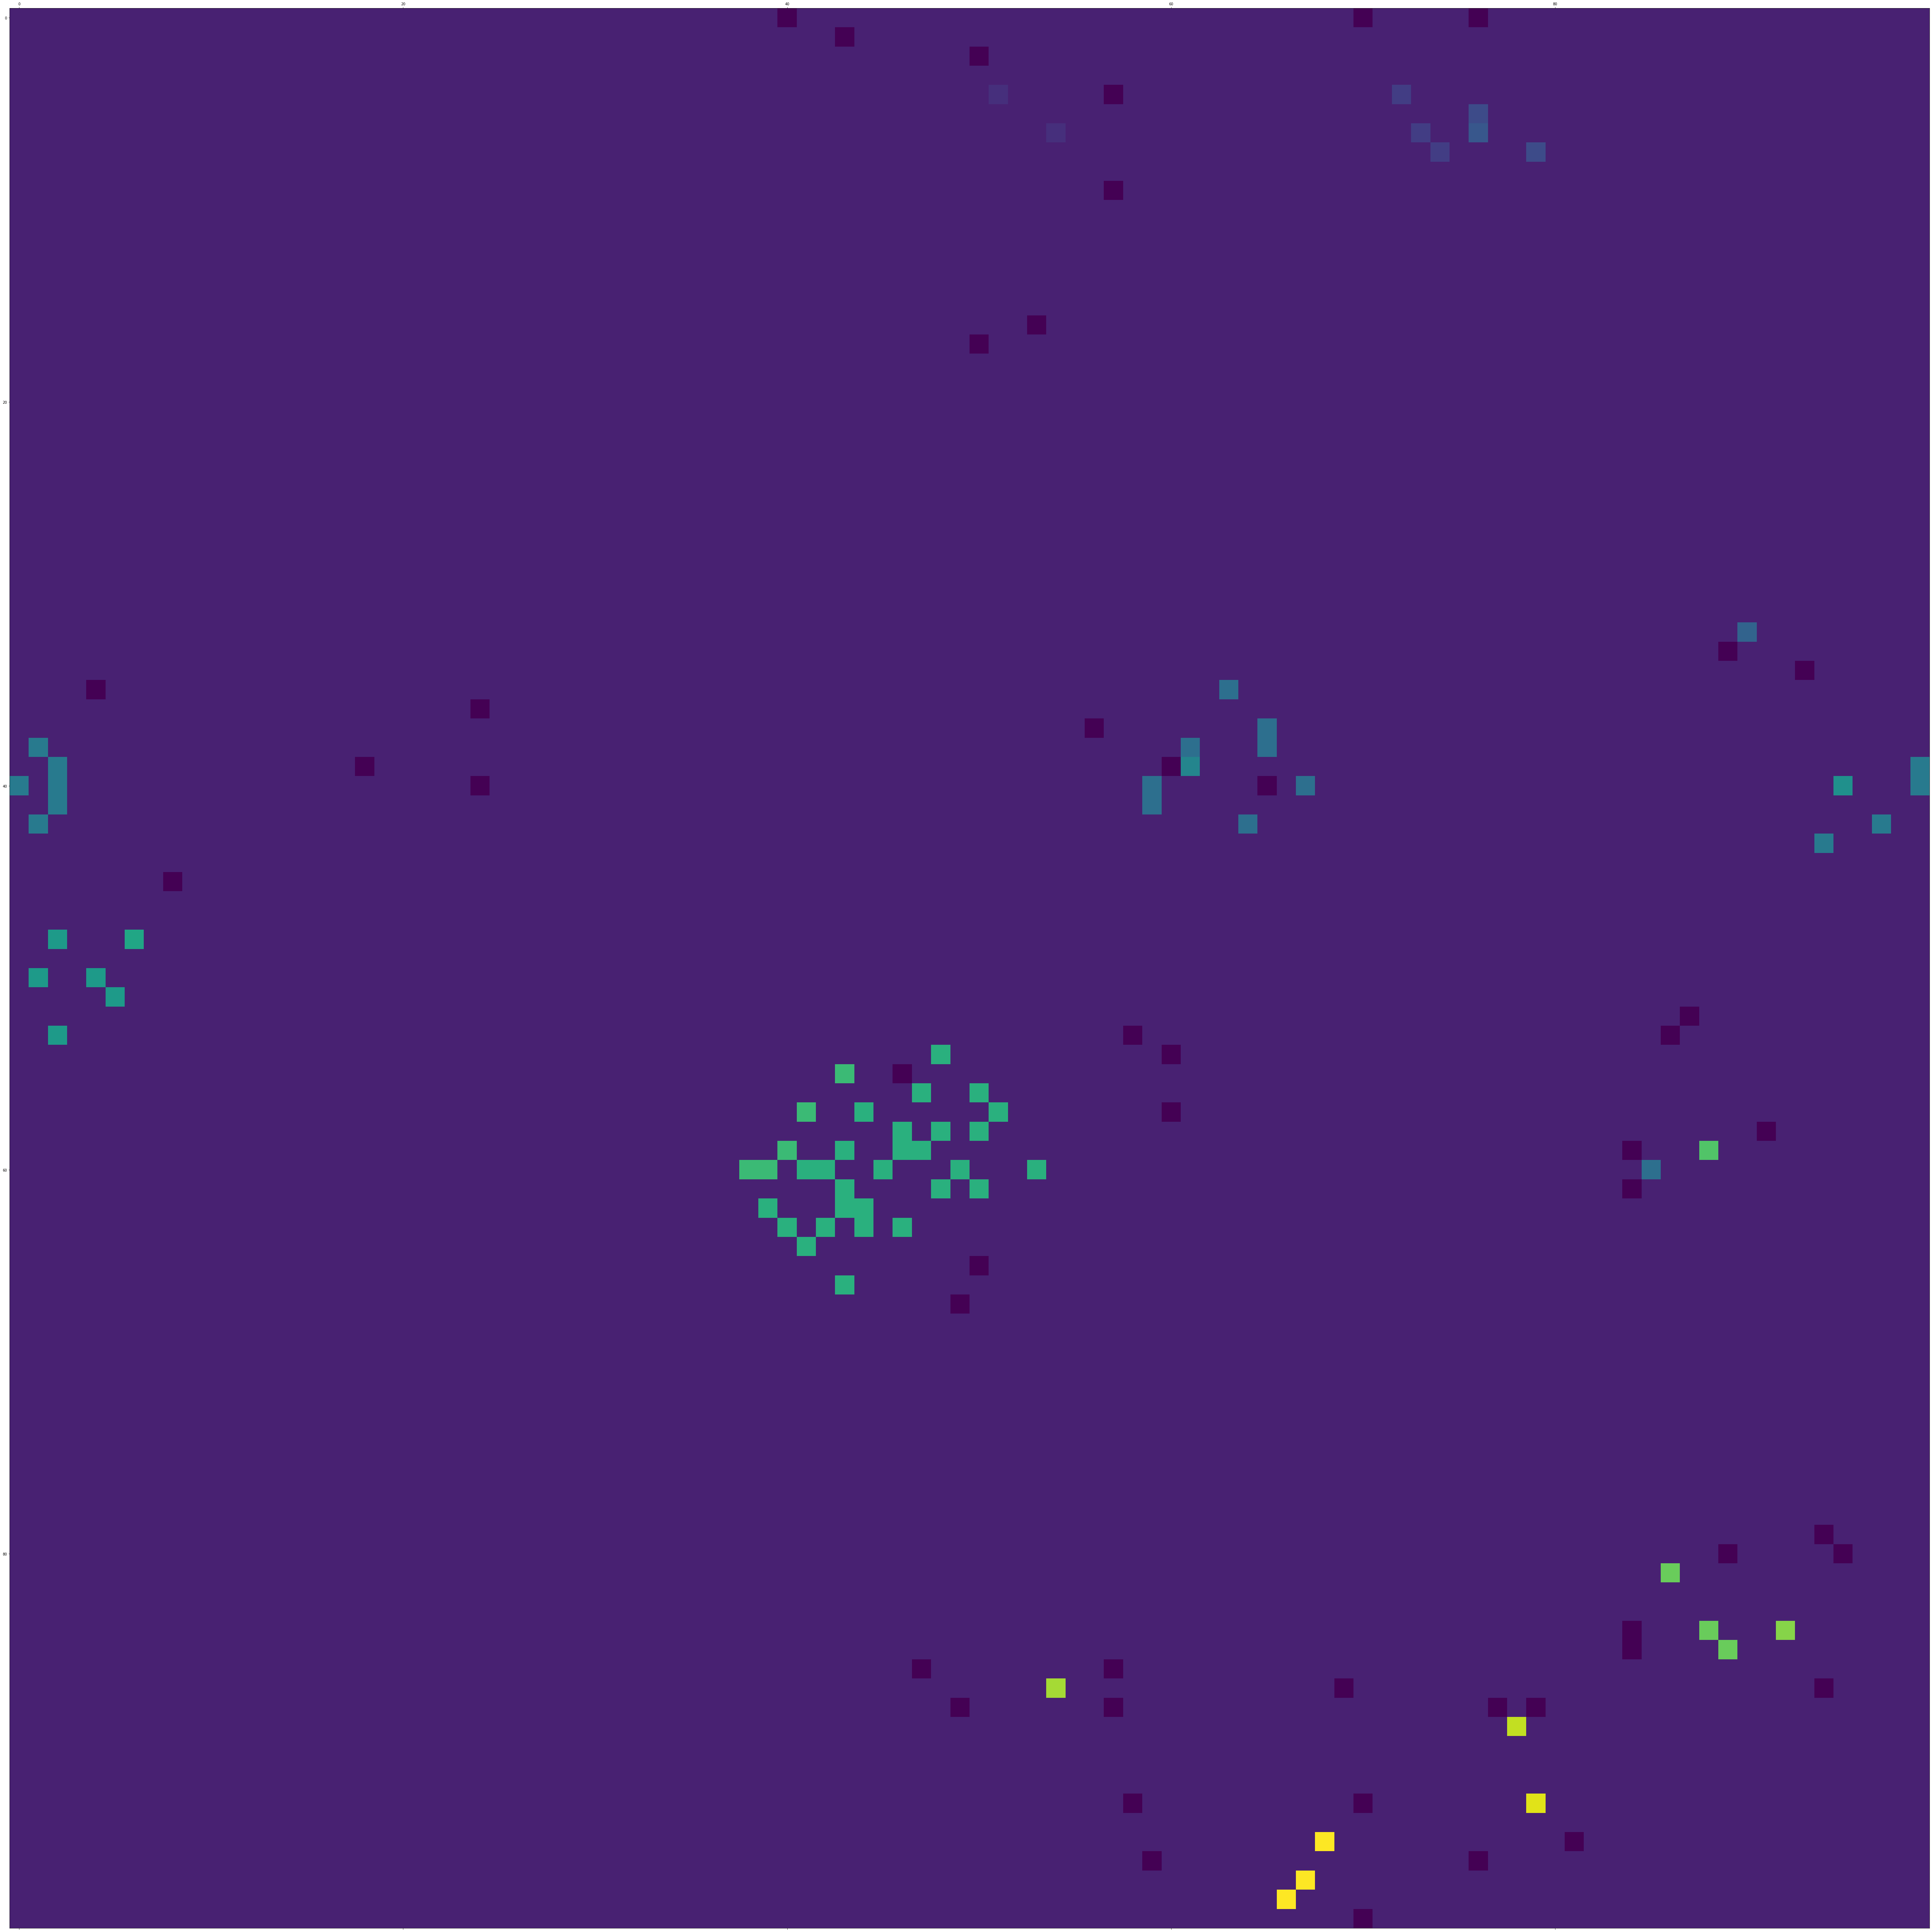

In [9]:
results['grid'].plot_grid(save_figure=True)

In [10]:
results

{'number_classes': 20, 'grid': <__main__.Grid at 0x1ef0f197910>}